In [1]:
##### Es necesario montar el drive para poder cargar el dataset
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
!git clone https://github.com/Rmejiaz/CrowdLayer

Cloning into 'CrowdLayer'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 71 (delta 7), reused 11 (delta 4), pack-reused 54
Unpacking objects: 100% (71/71), 286.12 KiB | 404.00 KiB/s, done.


In [3]:
cd CrowdLayer/

/kaggle/working/CrowdLayer


# Import required libraries

In [4]:
import numpy as np
import pandas as pd
import os 
import csv
import tensorflow as tf
import matplotlib.cm as cm
from matplotlib import pyplot as plt 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Rescaling
import keras

# packages for learning from crowds
from crowd_layer.crowd_layers import CrowdsClassification, MaskedMultiCrossEntropy
from crowd_layer.crowd_aggregators import CrowdsCategoricalAggregator
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.layers import BatchNormalization
 

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import os
import time
import sys

# prevent tensorflow from allocating the entire GPU memory at once
# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)
# seed_value= 43
# from numpy.random import seed
# seed(seed_value)
# tf.random.set_seed(seed_value)

# Data configuration

In [5]:
NUM_RUNS = 30
DATA_PATH_Tr = '/kaggle/input/labelme/LabelMe/train'
DATA_PATH_Te = '/kaggle/input/labelme/LabelMe/test'
DATA_PATH_Val = '/kaggle/input/labelme/LabelMe/valid'
N_CLASSES = 8
BATCH_SIZE = 128
N_EPOCHS = 100
N_ANNOT = 59



# Cargar datos con las etiquetas verdaderas.

In [6]:
Data_train = tf.keras.preprocessing.image_dataset_from_directory(
    directory = DATA_PATH_Tr,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(128, 128),
    shuffle=True,
    validation_split=None,
)

Data_test = tf.keras.preprocessing.image_dataset_from_directory(
    directory = DATA_PATH_Te,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(128, 128),
    shuffle=True,
    validation_split=None,
)

Data_valid = tf.keras.preprocessing.image_dataset_from_directory(
    directory = DATA_PATH_Val,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(128, 128),
    shuffle=True,
    validation_split=None,
)

Found 1000 files belonging to 8 classes.


2022-12-20 21:08:29.537365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 21:08:29.621701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 21:08:29.622456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 21:08:29.624725: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 1188 files belonging to 8 classes.
Found 500 files belonging to 8 classes.


# Define the base deep learning model


In [7]:
def create_model():
    
    #l1 = 1e-3
    base_model = Sequential()
    base_model.add(Rescaling(1./255,  input_shape=(128, 128, 3)))
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(32, (3, 3))) #,kernel_regularizer=regularizers.L1L2(l1=l1, l2=l1)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))
   
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(32, (3, 3))) #,kernel_regularizer=regularizers.L1L2(l1=l1, l2=l1)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))
    

    base_model.add(BatchNormalization())
    base_model.add(Conv2D(64, (3, 3))) #,kernel_regularizer=regularizers.L1L2(l1=l1, l2=l1)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))

    base_model.add(BatchNormalization())
    base_model.add(Conv2D(64, (3, 3))) #,kernel_regularizer=regularizers.L1L2(l1=l1, l2=l1)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))


    base_model.add(Flatten()) 
    base_model.add(BatchNormalization())
    base_model.add(Dense(256)) #,kernel_regularizer=regularizers.L1L2(l1=l1, l2=l1)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(Dropout(0.75))
    base_model.add(Dense(N_CLASSES))
    base_model.add(Activation('softmax'))

    base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm = 1.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return base_model

In [8]:
class_names = Data_valid.class_names
print(class_names)

['coast', 'forest', 'highway', 'insidecity', 'mountain', 'opencountry', 'street', 'tallbuilding']


2022-12-20 21:08:32.819055: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


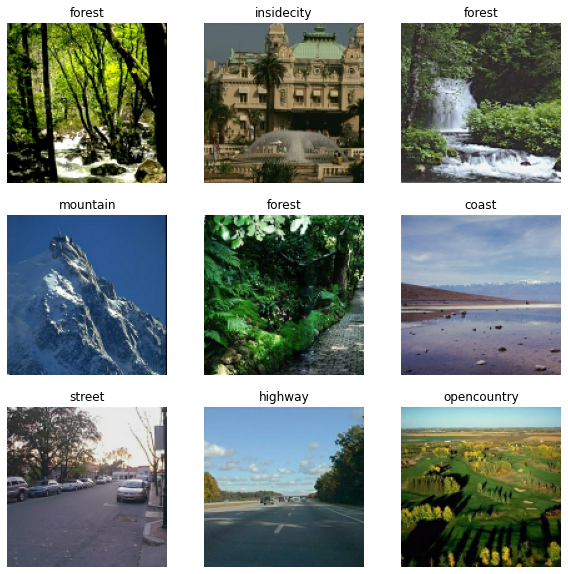

In [9]:
import matplotlib.pyplot as plt

 

plt.figure(figsize=(10, 10))
for images, labels in Data_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #print(images[0,1,:, 2])
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# callbacks = [
#     EarlyStopping(patience=10, verbose=1),
#     ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
#     ModelCheckpoint('model1.h5', verbose=1, save_best_only=True, save_weights_only=True)
# ]

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/70


2022-12-20 21:08:40.101436: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8/8 - 12s - loss: 3.2529 - accuracy: 0.3010 - val_loss: 61.7757 - val_accuracy: 0.1440
Epoch 2/70
8/8 - 2s - loss: 1.7618 - accuracy: 0.4930 - val_loss: 42.9284 - val_accuracy: 0.1300
Epoch 3/70
8/8 - 2s - loss: 1.3462 - accuracy: 0.5520 - val_loss: 16.7907 - val_accuracy: 0.1940
Epoch 4/70
8/8 - 2s - loss: 1.1214 - accuracy: 0.6230 - val_loss: 11.7302 - val_accuracy: 0.3280
Epoch 5/70
8/8 - 2s - loss: 0.9700 - accuracy: 0.6750 - val_loss: 8.0011 - val_accuracy: 0.3800
Epoch 6/70
8/8 - 2s - loss: 0.8522 - accuracy: 0.7150 - val_loss: 3.3832 - val_accuracy: 0.4720
Epoch 7/70
8/8 - 2s - loss: 0.7026 - accuracy: 0.7610 - val_loss: 3.5546 - val_accuracy: 0.4480
Epoch 8/70
8/8 - 2s - loss: 0.6109 - accuracy: 0.7840 - val_loss: 2.9201 - val_accuracy: 0.4860
Epoch 9/70
8/8 - 2s - loss: 0.6342 - accuracy: 0.7860 - val_loss: 4.4026 - val_accuracy: 0.3980
Epoch 10/70
8/8 - 2s - loss: 0.5509 - accuracy: 0.8120 - val_loss: 3.5404 - val_accuracy: 0.4920
Epoch 11/70
8/8 - 2s - loss: 0.5446 - accurac

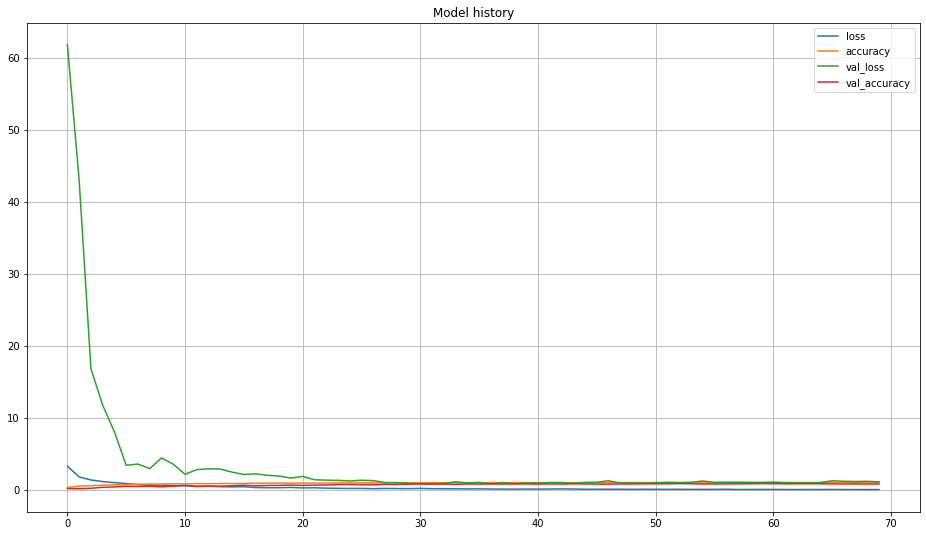

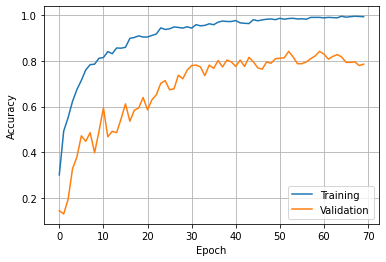

In [11]:
NUM_RUNS = 1
N_EPOCHS = 70


    # Create the results directory
# if  not 'results' in os.listdir():
#     os.mkdir('/kaggle/working/results')
AUC = np.zeros(NUM_RUNS)
val_acc_goldst = np.zeros(NUM_RUNS)

for i in range(NUM_RUNS):
    model = create_model()
    model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam(lr=1e-2, clipnorm = 1.0))
    trainHistory = model.fit(Data_train, validation_data=Data_valid, epochs=N_EPOCHS, verbose=2)  #callbacks=callbacks, 
    (loss, accuracy) = model.evaluate(Data_test)
    val_acc_goldst[i] = accuracy


    # Create the history figure
    plt.figure(figsize=(16,9))
    for l in  trainHistory.history:
        plt.plot( trainHistory.history[l],label=l)
    plt.title('Model history')
    plt.legend()
    plt.grid()

   
    
     #AUC

    val_AUC_metric = tf.keras.metrics.AUC(num_thresholds=3, from_logits = True)
    for x_batch_val, y_batch_val in Data_test:
        val_logits = model(x_batch_val.numpy(), training=False)
      # tf.print(y_batch_val)
        val_AUC_metric.update_state(y_batch_val, val_logits.numpy().argmax(axis=1).astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation AUC: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC

     # Save the figure
    i = 0
    flag = True
    while(flag==True):
        if (f'history{i}' in os.listdir('/kaggle/working')):
            i+=1
        else:
            plt.savefig(f'/kaggle/working/history{i}')
            flag=False

    plt.show()
df_gold = pd.DataFrame(val_acc_goldst)
df_gold.to_csv('/kaggle/working/labelme_GOLD.csv',index=False) # save to notebook output
  

plt.plot(trainHistory.history['accuracy'])
plt.plot(trainHistory.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()

In [12]:
val_acc_goldst

array([0.81481481])

In [13]:
 
AUC
     

array([0.86466283])

In [14]:

print('Average Accuracy: ', np.round(val_acc_goldst.mean(),4)*100) 
print('Average std: ',np.round(np.std(val_acc_goldst),4)*100)

Average Accuracy:  81.47999999999999
Average std:  0.0


In [15]:
print('Average Accuracy: ', np.round( AUC.mean(),4)*100) 
print('Average std: ',np.round(np.std( AUC),4)*100)

     

Average Accuracy:  86.47
Average std:  0.0


# Cargar datos con múltiples anotadores

In [16]:
# with open('../drive/Shareddrives/Multiple Anotators/CrowdLayer/Data/LabelMe/filenames_train.txt', 'r') as file:
#     reader = csv.reader(file)
#     Names = []
#     for row in reader:
#         Names.append(row[0])

# with open('../drive/Shareddrives/Multiple Anotators/CrowdLayer/Data/LabelMe/labels_train.txt', 'r') as file:
#     reader = csv.reader(file)
#     y_ = []
#     for row in reader:
#         y_.append(row[0])


# Data = pd.read_csv('../drive/Shareddrives/Multiple Anotators/CrowdLayer/Data/LabelMe/answers.txt', sep=" ", header=None)
# A_ = Data.loc[:,Data.sum() > -990]
# Y_ = A_.values

# # with open('../drive/Shareddrives/Multiple Anotators/CrowdLayer/Data/LabelMe/prepared/answers.npy', mode = 'rb') as file:
# #     Y_ = np.load(file)

# # with open('../drive/Shareddrives/Multiple Anotators/CrowdLayer/Data/LabelMe/prepared/labels_train.npy', mode = 'rb') as file:
# #     y_ = np.load(file)

# A = os.walk(DATA_PATH_Tr)
# Y = []
# y = []
# for r,d,files in A:
#   d.sort()
#   if len(files) != 0:
#     print(files)
#     for fil_ in sorted(files):
#       Y.append(Y_[Names.index(fil_),:])
#       y.append(int(y_[Names.index(fil_)]))

In [17]:
# Data_train_MA = tf.keras.preprocessing.image_dataset_from_directory(
#     directory = DATA_PATH_Tr,
#     labels=Y,
#     label_mode="int",
#     color_mode="rgb",
#     batch_size=BATCH_SIZE,
#     image_size=(128, 128),
#     shuffle=True,
#     validation_split=None,
# )

In [18]:
# with open('../drive/Shareddrives/Multiple Anotators/CrowdLayer/Data/LabelMe/labels_test.txt', 'r') as file:
#     reader = csv.reader(file)
#     y_te = []
#     for row in reader:
#         y_te.append(row[0])

# with open('../drive/Shareddrives/Multiple Anotators/CrowdLayer/Data/LabelMe/filenames_test.txt', 'r') as file:
#     reader = csv.reader(file)
#     Names = []
#     for row in reader:
#         Names.append(row[0])

# A = os.walk(DATA_PATH_Te)
# y_test = []
# for r,d,files in A:
#   d.sort()
#   if len(files) != 0:
#     print(files)
#     for fil_ in sorted(files):
#       y_test.append(int(y_te[Names.index(fil_)]))

In [19]:
# Data_test_MA = tf.keras.preprocessing.image_dataset_from_directory(
#     directory = DATA_PATH_Te,
#     labels=y_test,
#     label_mode="int",
#     color_mode="rgb",
#     batch_size=BATCH_SIZE,
#     image_size=(128, 128),
#     shuffle=True,
#     validation_split=None,
# )

# Auxiliary function for evaluating the models

In [20]:
# def eval_model(model, test_data, test_labels):
#     # testset accuracy
#     preds_test = model.predict(test_data)
#     preds_test_num = np.argmax(preds_test, axis=1)
#     accuracy_test = 1.0*np.sum(preds_test_num == test_labels) / len(test_labels)

#     return accuracy_test

# Proposed Model

In [21]:
# import sys
# sys.path.append("/content/drive/Shareddrives/Multiple Anotators/CrowdLayer/Models")
# from Multiple_Annotators_C_v1 import MultipleAnnotators_Classification

In [22]:
# MA = MultipleAnnotators_Classification(N_CLASSES, N_ANNOT)
# def create_model():
#   base_model = tf.keras.applications.VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(128, 128, 3),
#   )
#   base_model.trainable = False
#   inputs = keras.Input(shape=(128, 128, 3))
#   x = base_model(inputs)
#   x = keras.layers.Flatten()(x)
#   x = keras.layers.Dropout(0.5)(x)
#   x = keras.layers.Dense(256)(x)
#   x = keras.layers.BatchNormalization()(x)
#   x = keras.layers.Dropout(0.5)(x)
#   output = MA.CrowdLayer(x)
#   model = keras.Model(inputs=inputs,outputs=output)
#   return model

In [23]:

# val_acc = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS):
#   MA = MultipleAnnotators_Classification(N_CLASSES, N_ANNOT)
#   model = create_model()
#   model = MA.fit(model, Data_train_MA, N_EPOCHS)
#   val_acc[i] = MA.eval_model(Data_test_MA)
#   print("Validation acc: %.4f" % (float(val_acc[i]),))

In [24]:
# print(val_acc)

In [25]:
# r1 = np.mean(val_acc)
# print("\nMean: ", r1)
  
# r2 = np.std(val_acc)
# print("\nstd: ", r2)
  
# r3 = np.var(val_acc)
# print("\nvariance: ", r3)

In [26]:

# plt.plot(val_acc, range(NUM_RUNS))
# #plt.plot(h.history['val_accuracy'])
# plt.title('Model MA accuracy',fontsize=14, fontweight='bold')
# plt.ylabel('Accuracy',fontsize=14, fontweight='bold')
# #plt.xlabel('Epoch',fontsize=14, fontweight='bold')
# plt.legend(['Test'], loc='upper left')
# #plt.ylim(0.7, 1.0)
# plt.grid()
# plt.show()
